In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
directory = '/Users/filippo/Developer/tesi/results/hSBM/1000dococc2000fpkmthr'

In [62]:
l = 3

In [63]:
topics = pd.read_csv("%s/topsbm_level_%d_topic-dist.csv"%(directory,l), index_col=[0])
topics.head()

,doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 164,Topic 165,Topic 166,Topic 167,Topic 168,Topic 169,Topic 170,Topic 171,Topic 172,Topic 173
i_doc,,,,,,,,,,,,,,,,,,,,,
0,007f49fe-d251-4ae4-9313-86d765b13499,0.023256,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,009ff7e3-8bd3-4683-adf5-7b68a0859f35,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,00e2c524-8a29-46d7-bf88-ed5f9c3dcf32,0.000000,0.3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0
3,00eb7c26-84fd-4ab9-93a1-3d209dfc0f43,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,01188815-3676-4980-9cb8-7666169328f1,0.000000,0.0,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [64]:
ntopics = len(topics.keys())-1

In [65]:
np.sum(topics.loc[3].values[1:].reshape(ntopics,))

1.0

# hist on row

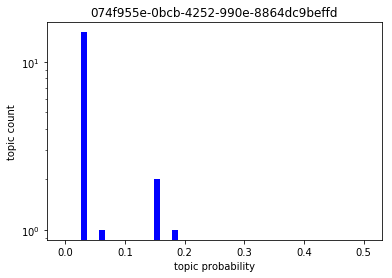

In [66]:
bins = 50
maximum = 0.5
sample = 25
fig=plt.figure()
range_ = (0-maximum*0.5/bins, maximum+maximum*0.5/bins)
plt.hist([x for x in topics.loc[sample].values[1:].reshape(ntopics,) if x>0], bins=bins, range=range_, color='b')
plt.yscale('log')
plt.xlabel("topic probability")
plt.ylabel("topic count")
plt.title(topics.loc[sample,'doc'])
plt.show()
fig.savefig("%s/topicsditr_%s.png"%(directory,sample))

# maximums distr

In [67]:
my_series = topics.max(numeric_only=True, axis = 1)
my_series.name = "maxval"

topics = topics.join(my_series)
topics.head()

,doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 165,Topic 166,Topic 167,Topic 168,Topic 169,Topic 170,Topic 171,Topic 172,Topic 173,maxval
i_doc,,,,,,,,,,,,,,,,,,,,,
0,007f49fe-d251-4ae4-9313-86d765b13499,0.023256,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.116279
1,009ff7e3-8bd3-4683-adf5-7b68a0859f35,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.222222
2,00e2c524-8a29-46d7-bf88-ed5f9c3dcf32,0.000000,0.3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.300000
3,00eb7c26-84fd-4ab9-93a1-3d209dfc0f43,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.121212
4,01188815-3676-4980-9cb8-7666169328f1,0.000000,0.0,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.302326


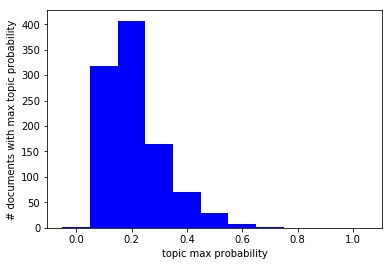

In [68]:
fig = plt.figure()
plt.hist(topics['maxval'], range=(-0.05,1.05), bins=11, color='b')
plt.xlabel("topic max probability")
plt.ylabel("# documents with max topic probability")
plt.show()
fig.savefig("%s/maxprobabilitytopicsditr.png"%directory)